## Simulador de Recorridos ciclistas

### Importamos librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle
import time

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Como tenemos procesado todo en el mismo fichero, lo cargamos

#path = '../Entrenamientos/Procesado_Tramos.xlsx'
path = '../Entrenamientos/Procesado_Tramos_simulacion.xlsx'
df = pd.read_excel(path)

### Filtramos datos

In [3]:
#Eliminar las filas que no tienen datos y seleccionamos la prueba que queremos simular
df = df[df["porc"]!=np.inf]
#df = df[df["prueba"]=="20180429_LEMG_195_90_R_C.gpx"]

In [4]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,84.000000,84.000000,84.000000,84.0,84.0,84.000000,84.0,84.000000,84.000000,84.000000
mean,41.500000,1220.797619,1252.880952,0.0,0.0,507.744281,0.0,-0.587996,-0.047731,19509.435551
std,24.392622,777.046195,781.656619,0.0,0.0,693.744429,0.0,5.336408,1.819731,12154.558566
min,0.000000,0.000000,25.000000,0.0,0.0,12.158278,0.0,-9.954147,-4.645913,329.544198
25%,20.750000,529.750000,609.500000,0.0,0.0,25.516494,0.0,-4.099877,-0.565377,9742.611994
50%,41.500000,1235.500000,1266.000000,0.0,0.0,145.726222,0.0,-1.248373,0.001432,19614.673821
75%,62.250000,1779.000000,1797.500000,0.0,0.0,784.964079,0.0,2.888754,0.363841,27829.260059
max,83.000000,2663.000000,2695.000000,0.0,0.0,3454.663686,0.0,9.997376,4.950157,42624.028333


In [6]:
#Se revisa que no existan datos anómalos
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba
0,0,0,25,0,0,344.041550,0,3.492273,1.596116,329.544198,xxxxxxxx_LEVS_195_90_R_E.gpx
1,1,25,26,0,0,13.567297,0,1.574548,-0.218832,344.041550,xxxxxxxx_LEVS_195_90_R_E.gpx
2,2,26,37,0,0,168.993513,0,1.731397,0.371159,509.985494,xxxxxxxx_LEVS_195_90_R_E.gpx
3,3,37,38,0,0,17.331806,0,1.575208,-0.067596,526.602360,xxxxxxxx_LEVS_195_90_R_E.gpx
4,4,38,41,0,0,48.498332,0,3.407638,0.074144,579.260182,xxxxxxxx_LEVS_195_90_R_E.gpx


(array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 1., 1., 4., 5., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 3., 6., 7., 6., 7., 4.,
        5., 3., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        2., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
        1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-4.64591325, -4.54995255, -4.45399185, -4.35803115, -4.26207045,
        -4.16610974, -4.07014904, -3.97418834, -3.87822764, -3.78226694,
        -3.68630624, -3.59034553, -3.49438483, -3.39842413, -3.30246343,
        -3.20650273, -3.11054202, -3.01458132, -2.91862062, -2.82265992,
        -2.72669922, -2.63073852, -2.53477781, -2.43881711, -2.34285641,
        -2.24689571, -2.15093501, -2.05497431, -1.9590136 , -1.8630529 ,
        -1.7670922 , -1.6711315 , -1.5751708 , -1.4792101 , -1.38324939,
        -1.28728869, -1.19132799, -1.09

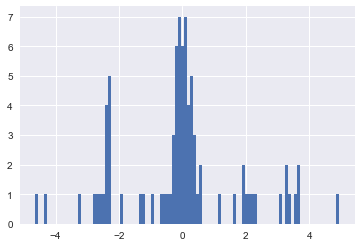

In [9]:
plt.hist(df['porc'],bins=100)

Vemos que la mayoría de tramos están centrados en porcentajes cercanos a 0, aunque también hay varios tramos de subidas y bajadas

In [10]:
#Prueba iterando en cada tramo con intervalos aleatorios con el modelo desarrollado CON TENSORFLOW (PRIMERA PASADA)

#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 210
pot_min = 65
pot_max = 285
ff_1 = 0.6
ff_2 = 0.35

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d, llevamos %d exitos y %d fracasos' %(fi,exito,fail))
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    bins_potencias = [0] * 30
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
   
    
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/2)-1
            max_random = abs(viento**2)+1
        else:
            max_random = (viento/2)+1
            min_random = (-1*viento**2)-1
            
        potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))*(np.random.randint(min_random,max_random)+100)/100
        #potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-100,100)
        potencia_min = pot_min+(pot_max-50-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
        potencia_max = pot_min+50+(pot_max-pot_min-50)/(1+ff_1*np.e**(ff_2*porc*-1))
                                            
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
        
        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        #acumulamos el tiempo que se pasa en cada agrupacion de potencias
        bins_potencias[int(potencia/10)] =bins_potencias[int(potencia/10)] + nuevo_tiempo[0]
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d y tiempo %d" %(fi, potencia_media, tiempo_acum))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-5) and (potencia_media < potencia_objetivo+5) and sum(bins_potencias[-5:])<1200:
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
        print("Tiempo por encimade de 250w:", sum(bins_potencias[-5:]))
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

Empezamos la prueba 0, llevamos 0 exitos y 0 fracasos
--- 2.6768627166748047 seconds ---
Intento 0 con potencia media 209 y tiempo 5145
Intento 1 con potencia media 211 y tiempo 5120
Intento 2 con potencia media 211 y tiempo 5119
Intento 3 con potencia media 210 y tiempo 5133
Intento 4 con potencia media 211 y tiempo 5122
Intento 5 con potencia media 211 y tiempo 5117
Tiempo por encimade de 250w: 1273.02197265625
Intento 6 con potencia media 211 y tiempo 5118
Intento 7 con potencia media 210 y tiempo 5134
Intento 8 con potencia media 210 y tiempo 5125
Tiempo por encimade de 250w: 1275.9191284179688
Intento 9 con potencia media 211 y tiempo 5118
Tiempo por encimade de 250w: 1208.7666931152344
Empezamos la prueba 10, llevamos 7 exitos y 3 fracasos
--- 7.262635707855225 seconds ---
Intento 10 con potencia media 211 y tiempo 5113
Intento 11 con potencia media 209 y tiempo 5128
Tiempo por encimade de 250w: 1271.5940856933594
Intento 12 con potencia media 210 y tiempo 5123
Tiempo por encimad

In [11]:
#Aqui solo se muestra el resutlado del ultimo exito... fase de validacion, luego se puede borrar
histo_pot = pd.DataFrame(bins_potencias)
histo_pot[potencia]=histo_pot.index.values*10
histo_pot.columns = ['segundos','potencia']
histo_pot

,segundos,potencia
0,0.000000,0
1,0.000000,10
2,0.000000,20
3,0.000000,30
4,0.000000,40
5,0.000000,50
6,0.000000,60
7,0.000000,70
8,0.000000,80
9,0.000000,90


In [12]:
sum(bins_potencias[-5:])

1126.4310302734375

In [13]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

,intento,pwr,secs,list
0,0,209.062958,5145.265137,"[[0, 207.49641867574059, 26.563322, 344.041550..."
1,1,211.526138,5120.097656,"[[0, 230.42687685344598, 28.012642, 344.041550..."
2,2,211.884583,5119.482910,"[[0, 212.4100882852489, 26.87389, 344.04155036..."
3,3,210.227234,5133.538574,"[[0, 228.78898698360987, 27.909119, 344.041550..."
4,4,211.673706,5122.135254,"[[0, 218.9616477645933, 27.287985, 344.0415503..."
5,6,211.596725,5118.319824,"[[0, 218.9616477645933, 27.287985, 344.0415503..."
6,7,210.075745,5134.783203,"[[0, 217.3237578947572, 27.184458, 344.0415503..."
7,10,211.717331,5113.179199,"[[0, 223.87531737410157, 27.59855, 344.0415503..."
8,13,211.108917,5126.118164,"[[0, 214.047978155085, 26.977415, 344.04155036..."
9,14,211.697571,5118.264160,"[[0, 222.23742750426547, 27.495031, 344.041550..."


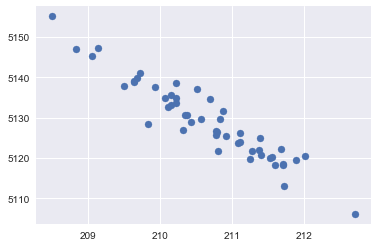

In [14]:
plt.scatter(ds['pwr'],ds['secs'])

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

(array([1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 3., 1., 1., 1.,
        0., 1., 3., 3., 2., 2., 1., 1., 1., 1., 4., 2., 0., 3., 0., 1., 1.,
        3., 1., 2., 1., 3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([208.5144043 , 208.59816559, 208.68192688, 208.76568817,
        208.84944946, 208.93321075, 209.01697205, 209.10073334,
        209.18449463, 209.26825592, 209.35201721, 209.4357785 ,
        209.51953979, 209.60330109, 209.68706238, 209.77082367,
        209.85458496, 209.93834625, 210.02210754, 210.10586884,
        210.18963013, 210.27339142, 210.35715271, 210.440914  ,
        210.52467529, 210.60843658, 210.69219788, 210.77595917,
        210.85972046, 210.94348175, 211.02724304, 211.11100433,
        211.19476563, 211.27852692, 211.36228821, 211.4460495 ,
        211.52981079, 211.61357208, 211.69733337, 211.78109467,
        211.86485596, 211.94861725, 212.03237854, 212.11613983,
        212.19990112, 212.28366241, 212.36742371, 212.451185  ,
      

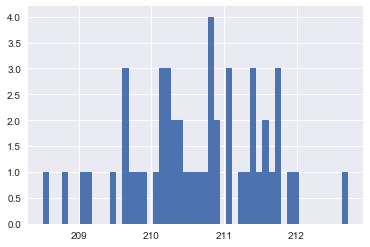

In [15]:
plt.hist(ds['pwr'],bins=50)

Histograma de potencias validas para la simulación

In [16]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

5106.19775390625

In [17]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']==a[:1].max()][['intento','list']])
ganadores

,intento,list
12,17,"[[0, 217.3237578947572, 27.184458, 344.0415503..."


In [31]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,217.323758,27.184458,344.041550,45.560944,1.596116,3.492273,17
1,1,195.844263,34.729618,13.567297,1.406358,-0.218832,1.574548,17
2,2,207.641309,32.529762,168.993513,18.702154,0.371159,1.731397,17
3,3,201.276550,34.313568,17.331806,1.818362,-0.067596,1.575208,17
4,4,199.668652,33.702175,48.498332,5.180496,0.074144,3.407638,17


In [32]:
df_ganador.describe()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.0
mean,41.500000,199.844299,33.602759,507.744281,60.788068,-0.047731,-0.587996,17.0
std,24.392622,32.044237,6.652650,693.744429,87.304180,1.819731,5.336408,0.0
min,0.000000,106.972071,17.322487,12.158278,1.308610,-4.645913,-9.954147,17.0
25%,20.750000,182.796328,31.937682,25.516494,2.863295,-0.565377,-4.099877,17.0
50%,41.500000,202.631771,33.588869,145.726222,16.025623,0.001432,-1.248373,17.0
75%,62.250000,219.076659,36.028197,784.964079,76.004414,0.363841,2.888754,17.0
max,83.000000,268.693264,48.895836,3454.663686,342.820923,4.950157,9.997376,17.0


(array([ 2.,  1.,  6.,  6.,  8., 21., 21.,  9.,  7.,  3.]),
 array([106.972071  , 123.14419029, 139.31630959, 155.48842888,
        171.66054818, 187.83266747, 204.00478677, 220.17690606,
        236.34902536, 252.52114465, 268.69326395]),
 <a list of 10 Patch objects>)

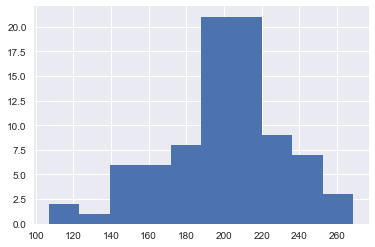

In [33]:
plt.hist(df_ganador['Potencia'].values)

(array([ 2.,  2., 13.,  3., 33., 15.,  5.,  3.,  7.,  1.]),
 array([-4.64591325, -3.68630624, -2.72669922, -1.7670922 , -0.80748518,
         0.15212183,  1.11172885,  2.07133587,  3.03094289,  3.9905499 ,
         4.95015692]),
 <a list of 10 Patch objects>)

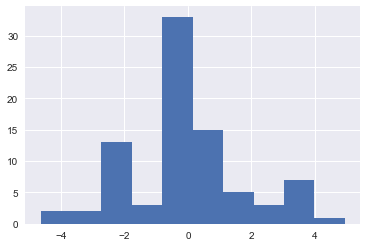

In [34]:
plt.hist(df_ganador['Pendiente'].values)

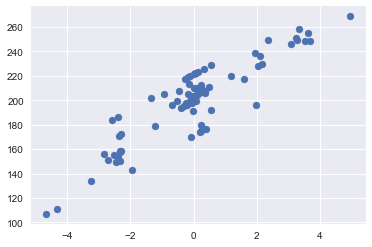

In [35]:
plt.scatter(df_ganador['Pendiente'].values,df_ganador['Potencia'].values)

La distribución de potencia es acorde a lo esperado

In [38]:
#Juntamos el resultado de la simulación con el recorrido original a efectos de comparativa posterior en Tableau
df_input = df[['tramo','pwr','spd','dist','time_seg','porc','viento_aparente']]
df_input.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
df_input['Intento'] = 'Original'
df_input.append([df_ganador]).to_excel('res_sim_ori.xlsx')
df_input.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,0,0,344.041550,0,1.596116,3.492273,Original
1,1,0,0,13.567297,0,-0.218832,1.574548,Original
2,2,0,0,168.993513,0,0.371159,1.731397,Original
3,3,0,0,17.331806,0,-0.067596,1.575208,Original
4,4,0,0,48.498332,0,0.074144,3.407638,Original


In [41]:
potencias_medias = df_ganador.groupby(['Tramos'])['Potencia'].agg('median')

#### Posible mejora del modelo, inicializando la potencia de cada tramo con el mejor resultado de la primera simulación

In [42]:
#CON TENSORFLOW (SEGUNDA PASADA)
#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 220
pot_min = 60
pot_max = 275
ff_1 = 0.3
ff_2 = 0.7

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/2)-1
            max_random = abs(viento*2)+1
        else:
            max_random = (viento/2)+1
            min_random = (-1*viento*2)-1
                
        potencia_aux = potencias_medias[i]*(np.random.randint(min_random,max_random)+100)/100
        potencia_min = pot_min+(pot_max-30-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
        potencia_max = pot_min+30+(pot_max-pot_min-30)/(1+ff_1*np.e**(ff_2*porc*-1))
                                            
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
    
        
        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-5) and (potencia_media < potencia_objetivo+5):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

Empezamos la prueba 0
--- 0.9859635829925537 seconds ---
Intento 0 con potencia media 210
Intento 1 con potencia media 211
Intento 2 con potencia media 211
Intento 3 con potencia media 211
Intento 4 con potencia media 211
Intento 5 con potencia media 211
Intento 6 con potencia media 211
Intento 7 con potencia media 212
Intento 8 con potencia media 211
Intento 9 con potencia media 211
Empezamos la prueba 10
--- 3.83866548538208 seconds ---
Intento 10 con potencia media 212
Intento 11 con potencia media 211
Intento 12 con potencia media 212
Intento 13 con potencia media 211
Intento 14 con potencia media 212
Intento 15 con potencia media 211
Intento 16 con potencia media 211
Intento 17 con potencia media 211
Intento 18 con potencia media 211
Intento 19 con potencia media 210
Empezamos la prueba 20
--- 6.7784388065338135 seconds ---
Intento 20 con potencia media 212
Intento 21 con potencia media 211
Intento 22 con potencia media 211
Intento 23 con potencia media 211
Intento 24 con potencia

KeyboardInterrupt: 

In [ ]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

In [ ]:
plt.scatter(ds['pwr'],ds['secs'])

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

In [ ]:
plt.hist(ds['pwr'],bins=50)

Histograma de potencias validas para la simulación

In [ ]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

In [ ]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']<=a[:50].max()][['intento','list']])
ganadores

In [ ]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

In [ ]:
df_ganador.describe()

In [ ]:
plt.hist(df_ganador['Potencia'])

In [ ]:
plt.scatter(df_ganador['Pendiente'],df_ganador['Potencia'])